In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#4 gene haplotype order and palette
firsta = ['S', 's']
seconda = ['A', 'a']
thirda = ['B', 'b']
fourtha = ['R', 'r']
hap_4gene_poss =[]

for a in firsta:
    for b in seconda:
        for c in thirda:
            for d in fourtha:
                hap_4gene_poss.append(a+b+c+d)
                
order = [0, 4, 3, 10, 2, 9, 8, 14, 1, 7, 6, 12, 5, 13, 11, 15]
hap_4gene_order = dict(zip(hap_4gene_poss, order))
 
num_cols = len(hap_4gene_poss)
cols = sns.color_palette("husl", num_cols)
col_4gene = dict(zip(hap_4gene_poss, cols))

In [4]:
#3 gene haplotype order and palette
firsta = ['S', 's']
seconda = ['A', 'a']
fourtha = ['R', 'r']
hap_3gene_poss =[]

for a in firsta:
    for b in seconda:
        for d in fourtha:
            hap_3gene_poss.append(a+b+d)
                
order = [0, 4, 3, 10, 2, 9, 8, 14, 1, 7, 6, 12, 5, 13, 11, 15]
hap_3gene_order = dict(zip(hap_3gene_poss, order))

num_cols = len(hap_3gene_poss)
cols = sns.color_palette("husl", num_cols)
col_3gene = dict(zip(hap_3gene_poss, cols))

In [5]:
#2 gene haplotype order and palette
firsta = ['C', 'c']
seconda = ['G', 'g']
hap_2gene_poss =[]

for a in firsta:
    for b in seconda:
        hap_2gene_poss.append(a+b)
                
order = [0, 1, 2, 3]
hap_2gene_order = dict(zip(hap_2gene_poss, order))
            
num_cols = len(hap_2gene_poss)
cols = sns.color_palette("husl", num_cols)
col_2gene = dict(zip(hap_2gene_poss, cols))

In [6]:
#Import the data and flip into a multi index 
df = pd.read_csv('../Data/Amp_data/allele_counts.tsv', header = [0,1,2], index_col = 0, sep='\t')
df = df.stack([0,1,2])
df = df.reorder_levels([1,0,2,3])
df = df.to_frame()  #puts everything back in a dataframe
df.columns = ['Reads']
df['Plate'] = df.index.get_level_values(0)  #These lines send indexes to columns
df['Well'] = df.index.get_level_values(1)
df['Amplicon'] = df.index.get_level_values(2)
df['Genotype'] = df.index.get_level_values(3)
df[['Patient', 'one', 'two']] = df['Amplicon'].str.split('_', expand = True)
df = df.drop(columns = ['one', 'two'])

#Import information about plate cell type and patient
key = pd.read_excel('../Data/Amp_data/Amplicon_metadata_fixed.xlsx', sheet_name = 'PlateID')
key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells', 'fcs-fle' ], axis=1)
key.rename(columns = {'Comments2':'Plate'}, inplace = True)
key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)

#Make a dictionary to associate plates with patients and plate with cell type
plate_pt_dict = dict(zip(key.Plate, key.Patient))
plate_cell_dict = dict(zip(key.Plate, key.Celltype))

#Set up some lists for iteration
patients = ['RN', 'EL', 'GR']
plates = df['Plate'].drop_duplicates().to_list()
amplicons = df['Amplicon'].drop_duplicates().to_list()
genos = df['Genotype'].drop_duplicates().to_list()
wells = df['Well'].drop_duplicates().to_list()

#Now just look at RN data, and apply filters to identify cells with enough reads/amplicon
#RN_allele_plate is the key dataset going forward
RN_allele_plate = df.loc[df['Patient'].isin(['RN'])] #Make df with just RN data
RN_allele_plate = RN_allele_plate.drop(columns = 'Patient') #Drop the Patient ID column and other unwanted cols
RN_allele_plate['Cell_type'] = RN_allele_plate['Plate'].replace(plate_cell_dict)
RN_allele_plate['Plate_Well'] = RN_allele_plate['Plate'].astype(str) + '_' + RN_allele_plate['Well'].astype(str)

#Make list of cell types
celltype = sorted(RN_allele_plate['Cell_type'].drop_duplicates().to_list())
celltype

['CD34', 'CD34+/38-', 'Monocytes', 'NEs', 'nBCs']

In [7]:
#Apply filters to data and export as a list 
df = RN_allele_plate.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
print('The columns (L-R) are;', list(df.columns))

#Find the cells/wells that contain >100 reads for the gDNA amplicons except TET2b and turn into a list
df1 = RN_allele_plate.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
df1 = df1.iloc[:, [1,2,3]] 
df1 = df1.loc[(df1 >= 100).all(axis=1)] #df1 contains just the rows with cells we want - use this to create a filter or key
df1 = df1.stack()
df1['Plate'] = df1.index.get_level_values(0)  #These lines send indexes to columns
df1['Well'] = df1.index.get_level_values(1)
df1['Plate_Well'] = df1['Plate'].astype(str) + '_' + df1['Well'].astype(str)
gene3_100cut = df1['Plate_Well'].drop_duplicates().to_list() #RN_wells is the list of wells that fulfill the desired criteria
gene3_100cut_amps = df1.index.get_level_values(2).drop_duplicates().to_list()
print('Cells with 100 reads for 3 genes (plate1) = ', len(gene3_100cut))

#Find the cells/wells that contain >15 reads for the gDNA amplicons  and turn into a list
df2 = RN_allele_plate.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
df2 = df2.iloc[:, [1,2,3,5]] 
df2 = df2.loc[(df2 >= 15).all(axis=1)] #df2 contains just the rows with cells we want - use this to create a filter or key
df2 = df2.stack()
df2['Plate'] = df2.index.get_level_values(0)  #These lines send indexes to columns
df2['Well'] = df2.index.get_level_values(1)
df2['Plate_Well'] = df2['Plate'].astype(str) + '_' + df2['Well'].astype(str)
gene4_15cut = df2['Plate_Well'].drop_duplicates().to_list() #RN_wells is the list of wells that fulfill the desired criteria
gene4_15cut_amps = df2.index.get_level_values(2).drop_duplicates().to_list()
print('Cells with 15 reads for 4 genes (plate2) = ', len(gene4_15cut))

#Find cells with 50 reads for RUNX1 cDNA or gDNA to compare methods
df3 = RN_allele_plate.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
df3 = df3.iloc[:, [0,1]] 
df3 = df3.loc[(df3 >= 50).all(axis=1)]
df3 = df3.stack()
df3['Plate'] = df3.index.get_level_values(0)  #These lines send indexes to columns
df3['Well'] = df3.index.get_level_values(1)
df3['Plate_Well'] = df3['Plate'].astype(str) + '_' + df3['Well'].astype(str)
gene1_50cut = df3['Plate_Well'].drop_duplicates().to_list()
gene1_50cut_amps = df3.index.get_level_values(2).drop_duplicates().to_list()
print('Cells with 50 reads for RUNX1 cDNA and gDNA (plate3) = ', len(gene1_50cut))

#Find the cells/wells that contain >10 reads for the gDNA amplicons  and turn into a list
df4 = RN_allele_plate.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
df4 = df4.iloc[:, [1,2,3,5]] 
df4 = df4.loc[(df4 >= 10).all(axis=1)] #df4 contains just the rows with cells we want - use this to create a filter or key
df4 = df4.stack()
df4['Plate'] = df4.index.get_level_values(0)  #These lines send indexes to columns
df4['Well'] = df4.index.get_level_values(1)
df4['Plate_Well'] = df4['Plate'].astype(str) + '_' + df4['Well'].astype(str)
gene4_10cut = df4['Plate_Well'].drop_duplicates().to_list() #RN_wells is the list of wells that fulfill the desired criteria
gene4_10cut_amps = df4.index.get_level_values(2).drop_duplicates().to_list()
print('Cells with 10 reads for 4 genes (plate4) = ', len(gene4_10cut))

#Find the cells/wells that contain >50 reads for the gDNA amplicons except TET2b and turn into a list
df5 = RN_allele_plate.groupby(['Plate', 'Well', 'Amplicon']).sum().unstack()
df5 = df5.iloc[:, [1,2,3]] 
df5 = df5.loc[(df5 >= 50).all(axis=1)] #df5 contains just the rows with cells we want - use this to create a filter or key
df5 = df5.stack()
df5['Plate'] = df5.index.get_level_values(0)  #These lines send indexes to columns
df5['Well'] = df5.index.get_level_values(1)
df5['Plate_Well'] = df5['Plate'].astype(str) + '_' + df5['Well'].astype(str)
gene3_50cut = df5['Plate_Well'].drop_duplicates().to_list() #RN_wells is the list of wells that fulfill the desired criteria
gene3_50cut_amps = df5.index.get_level_values(2).drop_duplicates().to_list()
print('Cells with 50 reads for 3 genes (plate5) = ', len(gene3_50cut))


plate_key = ('Cells with 100 reads for 3 genes (plate1), Cells with 15 reads for 4 genes (plate2), Cells with 50 reads for RUNX1 cDNA and gDNA (plate3), Cells with 10 reads for 4 genes (plate4)', 'Cells with 50 reads for 4 genes (plate 5)')

The columns (L-R) are; [('Reads', 'RN_RUNX1_c'), ('Reads', 'RN_RUNX1_g'), ('Reads', 'RN_SRSF2'), ('Reads', 'RN_TET2a'), ('Reads', 'RN_TET2b_c'), ('Reads', 'RN_TET2b_g')]
Cells with 100 reads for 3 genes (plate1) =  794
Cells with 15 reads for 4 genes (plate2) =  162
Cells with 50 reads for RUNX1 cDNA and gDNA (plate3) =  1645
Cells with 10 reads for 4 genes (plate4) =  253
Cells with 50 reads for 3 genes (plate5) =  1234


The number of haplotypes present is:  8


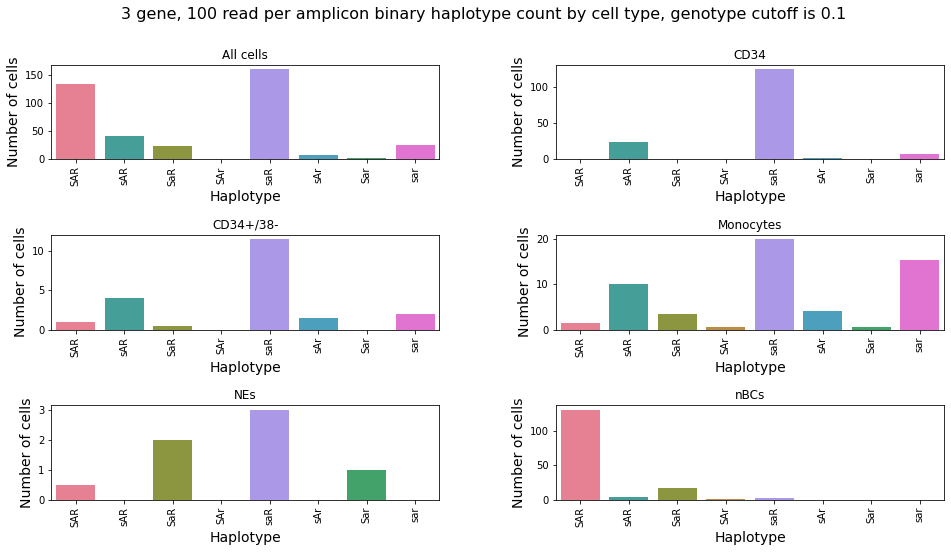

In [8]:
#Start with df1, gDNA amplicons except TET2b, filter list gene3_100cut
cutoff1 = 0.1 #Put haplotype cutoff here

plate1 = RN_allele_plate[RN_allele_plate['Plate_Well'].isin(gene3_100cut)]
plate1 = plate1[plate1['Amplicon'].isin(gene3_100cut_amps)] #Need to manually add amplicons for each subset

#Calculate the allele frequency
plate1 = plate1.iloc[:, 0:1].unstack(level = 3)
plate1['Total'] = plate1.iloc[: , 0] + plate1.iloc[: , 1]
plate1['Mut_freq'] = plate1.iloc[:, 0]/plate1['Total']

#Assign Wt or MT to each allele
plate1 = plate1.drop(columns = ['Reads', 'Total'])

conditions = [(plate1['Mut_freq'] <= cutoff1), (plate1['Mut_freq']) > cutoff1 ]
values = ['w', 'm']
plate1['Genotype'] = np.select(conditions, values)
plate1 = plate1.drop(columns = ['Mut_freq']).unstack(2)
plate1.columns = gene3_100cut_amps

plate1.iloc[:,0].replace({'w':'R','m':'r' }, inplace = True)
plate1.iloc[:,1].replace({'w':'S','m':'s' }, inplace = True)
plate1.iloc[:,2].replace({'w':'A','m':'a' }, inplace = True)
plate1['Haplotype'] = plate1.iloc[:,1] + plate1.iloc[:,2] + plate1.iloc[:,0]
plate1['Cell_type'] = plate1.index.get_level_values(0)
plate1['Cell_type'] = plate1['Cell_type'].replace(plate_cell_dict)

print('The number of haplotypes present is: ', len(plate1['Haplotype'].drop_duplicates().to_list()))

#Plot two haplotype data for 3 gene 100 amplicon set - second method to add colour for each haplotype
fig, axes = plt.subplots(3,2, figsize = (16,8))
fig.subplots_adjust(hspace = 0.8, wspace=.3)
ax = axes.ravel()
count = 0

c = plate1['Haplotype'].value_counts().rename_axis('hap').reset_index(name='counts')

#if any haplotype is not present, add it into the frame with freq 0 hap_3gene_poss has the possibilities
for h in hap_3gene_poss:
    if h in c['hap']:
        continue
    else:
        dfh = pd.DataFrame([[h, 0]], columns= ['hap', 'counts'])
        c = c.append(dfh)
        
c['order'] = c['hap']
c = c.replace({'order': hap_3gene_order})
c = c.sort_values(by=['order'])
d = c['counts'].sum()
c['proportion'] = c['counts']/d

ax[0] = sns.barplot(x='hap', y='counts', data = c, palette = col_3gene, ax = ax[count], ci = None) #fro scatter add  hue = 'hap'
ax[0].set_title('All cells') 
ax[0].set_ylabel('Number of cells', fontsize = 14)
ax[0].set_xlabel('Haplotype', fontsize = 14)
ax[0].tick_params(axis='x', labelrotation = 90)
#ax[0].set_ylim(0.001,0.999)
#ax[count].set_yscale('logit') #use this only with scatterplot

for cell in celltype:
    count += 1
    
    if plate1.loc[plate1['Cell_type'].isin([cell])].empty ==False:
    
        a = plate1.loc[plate1['Cell_type'].isin([cell])]['Haplotype'].value_counts().rename_axis('hap').reset_index(name='counts')
        #if any haplotype is not present, add it into the frame with freq 0 hap_3gene_poss has the possibilities
        for h in hap_3gene_poss:
            if h in a['hap']:
                continue
            else:
                dfh = pd.DataFrame([[h, 0]], columns= ['hap', 'counts'])
                a = a.append(dfh)
            
        a['order'] = a['hap']
        a = a.replace({'order': hap_3gene_order})
        a = a.sort_values(by=['order'])
        b = a['counts'].sum()
        a['proportion'] = a['counts']/b
    
        ax[count] = sns.barplot(x='hap', y='counts', data = a, palette = col_3gene,  ax = ax[count], ci = None) #for scatter add  hue = 'hap'
        ax[count].set_title(str(cell)) 
        ax[count].set_ylabel('Number of cells', fontsize = 14)
        ax[count].set_xlabel('Haplotype', fontsize = 14)
        ax[count].tick_params(axis='x', labelrotation = 90)
        #ax[count].set_ylim(0.001,0.999)
        #ax[count].set_yscale('logit') #use this only with scatterplot
        
    else:
        continue

fig.suptitle('3 gene, 100 read per amplicon binary haplotype count by cell type, genotype cutoff is ' + str(cutoff1), fontsize=16)
fig.savefig('../Results/Haplotypes/Haplotype_3gen_100amp_cutoff_'+str(cutoff1)+ '.png',dpi=300)  
#plt.close()

The number of haplotypes present is:  12


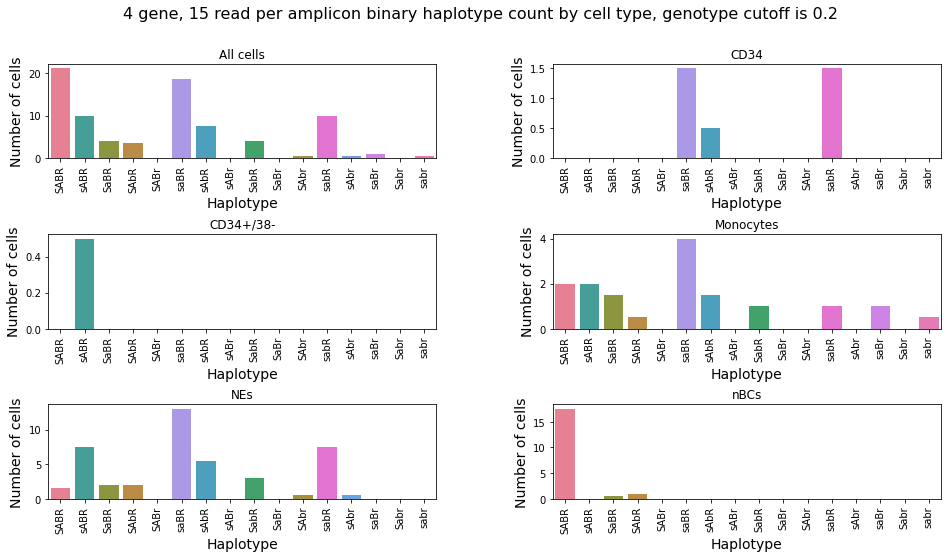

In [9]:
#Start with df2, gDNA amplicons gene4_15cut
cutoff2 = 0.2 #Put haplotype cutoff here

plate2 = RN_allele_plate[RN_allele_plate['Plate_Well'].isin(gene4_15cut)]
plate2 = plate2[plate2['Amplicon'].isin(gene4_15cut_amps)] #Need to manually add amplicons for each subset

#Calculate the allele frequency
plate2 = plate2.iloc[:, 0:1].unstack(level = 3)
plate2['Total'] = plate2.iloc[: , 0] + plate2.iloc[: , 1]
plate2['Mut_freq'] = plate2.iloc[:, 0]/plate2['Total']

#Assign Wt or MT to each allele
plate2 = plate2.drop(columns = ['Reads', 'Total'])

conditions = [(plate2['Mut_freq'] <= cutoff2), (plate2['Mut_freq']) > cutoff2 ]
values = ['w', 'm']
plate2['Genotype'] = np.select(conditions, values)
plate2 = plate2.drop(columns = ['Mut_freq']).unstack(2)
plate2.columns = gene4_15cut_amps

plate2.iloc[:,0].replace({'w':'R','m':'r' }, inplace = True)
plate2.iloc[:,1].replace({'w':'S','m':'s' }, inplace = True)
plate2.iloc[:,2].replace({'w':'A','m':'a' }, inplace = True)
plate2.iloc[:,3].replace({'w':'B','m':'b' }, inplace = True)
plate2['Haplotype'] = plate2.iloc[:,1] + plate2.iloc[:,2] + plate2.iloc[:,3] + plate2.iloc[:,0]
plate2['Cell_type'] = plate2.index.get_level_values(0)
plate2['Cell_type'] = plate2['Cell_type'].replace(plate_cell_dict)

print('The number of haplotypes present is: ', len(plate2['Haplotype'].drop_duplicates().to_list()))

#Plot two haplotype data for 4 gene 15 amplicon set - second method to add colour for each haplotype
fig, axes = plt.subplots(3,2, figsize = (16,8))
fig.subplots_adjust(hspace = 0.8, wspace=.3)
ax = axes.ravel()
count = 0

c = plate2['Haplotype'].value_counts().rename_axis('hap').reset_index(name='counts')

#if any haplotype is not present, add it into the frame with freq 0 hap_3gene_poss has the possibilities
for h in hap_4gene_poss:
    if h in c['hap']:
        continue
    else:
        dfh = pd.DataFrame([[h, 0]], columns= ['hap', 'counts'])
        c = c.append(dfh)
        
c['order'] = c['hap']
c = c.replace({'order': hap_4gene_order})
c = c.sort_values(by=['order'])
d = c['counts'].sum()
c['proportion'] = c['counts']/d

ax[0] = sns.barplot(x='hap', y='counts', data = c, palette = col_4gene, ax = ax[count], ci = None) #fro scatter add  hue = 'hap'
ax[0].set_title('All cells') 
ax[0].set_ylabel('Number of cells', fontsize = 14)
ax[0].set_xlabel('Haplotype', fontsize = 14)
ax[0].tick_params(axis='x', labelrotation = 90)
#ax[0].set_ylim(0.001,0.999)
#ax[count].set_yscale('logit') #use this only with scatterplot

for cell in celltype:
    count += 1
    
    if plate2.loc[plate2['Cell_type'].isin([cell])].empty ==False:
    
        a = plate2.loc[plate2['Cell_type'].isin([cell])]['Haplotype'].value_counts().rename_axis('hap').reset_index(name='counts')
        
        #if any haplotype is not present, add it into the frame with freq 0 hap_3gene_poss has the possibilities
        for h in hap_4gene_poss:
            if h in a['hap']:
                continue
            else:
                dfh = pd.DataFrame([[h, 0]], columns= ['hap', 'counts'])
                a = a.append(dfh)
                
        a['order'] = a['hap']
        a = a.replace({'order': hap_4gene_order})
        a = a.sort_values(by=['order'])
        b = a['counts'].sum()
        a['proportion'] = a['counts']/b
    
        ax[count] = sns.barplot(x='hap', y='counts', data = a, palette = col_4gene,  ax = ax[count], ci = None) #for scatter add  hue = 'hap'
        ax[count].set_title(str(cell)) 
        ax[count].set_ylabel('Number of cells', fontsize = 14)
        ax[count].set_xlabel('Haplotype', fontsize = 14)
        ax[count].tick_params(axis='x', labelrotation = 90)
        #ax[count].set_ylim(0.001,0.999)
        #ax[count].set_yscale('logit') #use this only with scatterplot
        
    else:
        continue

fig.suptitle('4 gene, 15 read per amplicon binary haplotype count by cell type, genotype cutoff is ' + str(cutoff2), fontsize=16)
fig.savefig('../Results/Haplotypes/Haplotype_4gen_15amp_cutoff_'+str(cutoff2)+ '.png',dpi=300)   
#plt.close()

The number of haplotypes present is:  12


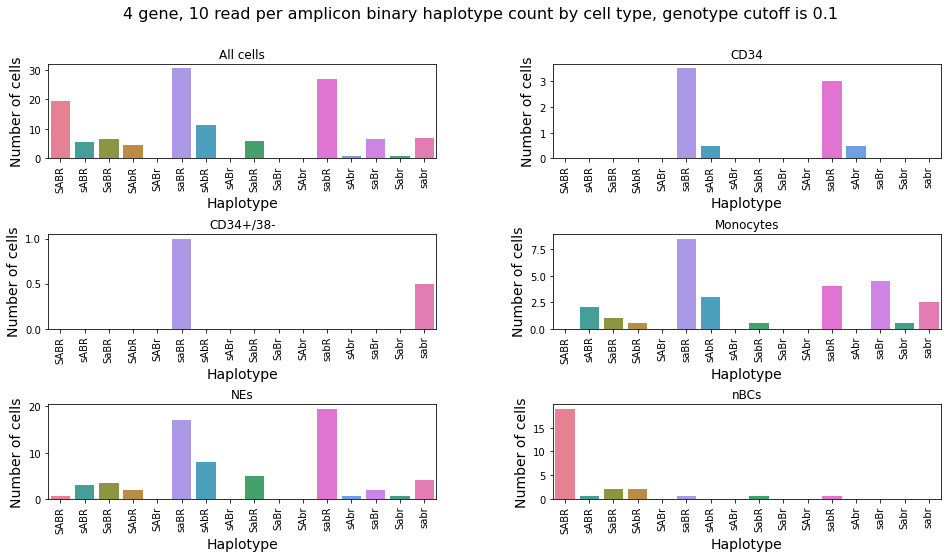

In [10]:
#Start with df4, gDNA amplicons gene4_10cut
cutoff4 = 0.1 #Put haplotype cutoff here

plate4 = RN_allele_plate[RN_allele_plate['Plate_Well'].isin(gene4_10cut)]
plate4 = plate4[plate4['Amplicon'].isin(gene4_10cut_amps)] #Need to manually add amplicons for each subset

#Calculate the allele frequency
plate4 = plate4.iloc[:, 0:1].unstack(level = 3)
plate4['Total'] = plate4.iloc[: , 0] + plate4.iloc[: , 1]
plate4['Mut_freq'] = plate4.iloc[:, 0]/plate4['Total']

#Assign Wt or MT to each allele
plate4 = plate4.drop(columns = ['Reads', 'Total'])

conditions = [(plate4['Mut_freq'] <= cutoff4), (plate4['Mut_freq']) > cutoff4 ]
values = ['w', 'm']
plate4['Genotype'] = np.select(conditions, values)
plate4 = plate4.drop(columns = ['Mut_freq']).unstack(2)
plate4.columns = gene4_10cut_amps

plate4.iloc[:,0].replace({'w':'R','m':'r' }, inplace = True)
plate4.iloc[:,1].replace({'w':'S','m':'s' }, inplace = True)
plate4.iloc[:,2].replace({'w':'A','m':'a' }, inplace = True)
plate4.iloc[:,3].replace({'w':'B','m':'b' }, inplace = True)
plate4['Haplotype'] = plate4.iloc[:,1] + plate4.iloc[:,2] + plate4.iloc[:,3] + plate4.iloc[:,0]
plate4['Cell_type'] = plate4.index.get_level_values(0)
plate4['Cell_type'] = plate4['Cell_type'].replace(plate_cell_dict)

print('The number of haplotypes present is: ', len(plate4['Haplotype'].drop_duplicates().to_list()))

#Plot two haplotype data for 4 gene 10 amplicon set - second method to add colour for each haplotype
fig, axes = plt.subplots(3,2, figsize = (16,8))
fig.subplots_adjust(hspace = 0.8, wspace=.3)
ax = axes.ravel()
count = 0

c = plate4['Haplotype'].value_counts().rename_axis('hap').reset_index(name='counts')

#if any haplotype is not present, add it into the frame with freq 0 hap_3gene_poss has the possibilities
for h in hap_4gene_poss:
    if h in c['hap']:
        continue
    else:
        dfh = pd.DataFrame([[h, 0]], columns= ['hap', 'counts'])
        c = c.append(dfh)
c['order'] = c['hap']
c = c.replace({'order': hap_4gene_order})
c = c.sort_values(by=['order'])
d = c['counts'].sum()
c['proportion'] = c['counts']/d

ax[0] = sns.barplot(x='hap', y='counts', data = c, palette = col_4gene, ax = ax[count], ci = None) #fro scatter add  hue = 'hap'
ax[0].set_title('All cells') 
ax[0].set_ylabel('Number of cells', fontsize = 14)
ax[0].set_xlabel('Haplotype', fontsize = 14)
ax[0].tick_params(axis='x', labelrotation = 90)
#ax[0].set_ylim(0.001,0.999)
#ax[count].set_yscale('logit') #use this only with scatterplot

for cell in celltype:
    count += 1
    
    if plate4.loc[plate4['Cell_type'].isin([cell])].empty ==False:
    
        a = plate4.loc[plate4['Cell_type'].isin([cell])]['Haplotype'].value_counts().rename_axis('hap').reset_index(name='counts')
        #if any haplotype is not present, add it into the frame with freq 0 hap_3gene_poss has the possibilities
        for h in hap_4gene_poss:
            if h in a['hap']:
                continue
            else:
                dfh = pd.DataFrame([[h, 0]], columns= ['hap', 'counts'])
                a = a.append(dfh)
                
        a['order'] = a['hap']
        a = a.replace({'order': hap_4gene_order})
        a = a.sort_values(by=['order'])
        b = a['counts'].sum()
        a['proportion'] = a['counts']/b
    
        ax[count] = sns.barplot(x='hap', y='counts', data = a, palette = col_4gene,  ax = ax[count], ci = None) #for scatter add  hue = 'hap'
        ax[count].set_title(str(cell)) 
        ax[count].set_ylabel('Number of cells', fontsize = 14)
        ax[count].set_xlabel('Haplotype', fontsize = 14)
        ax[count].tick_params(axis='x', labelrotation = 90)
        #ax[count].set_ylim(0.001,0.999)
        #ax[count].set_yscale('logit') #use this only with scatterplot
        
    else:
        continue

fig.suptitle('4 gene, 10 read per amplicon binary haplotype count by cell type, genotype cutoff is ' + str(cutoff4), fontsize=16)
fig.savefig('../Results/Haplotypes/Haplotype_4gen_10amp_cutoff_'+str(cutoff4)+ '.png',dpi=300)   
#plt.close()


The number of haplotypes present is:  4


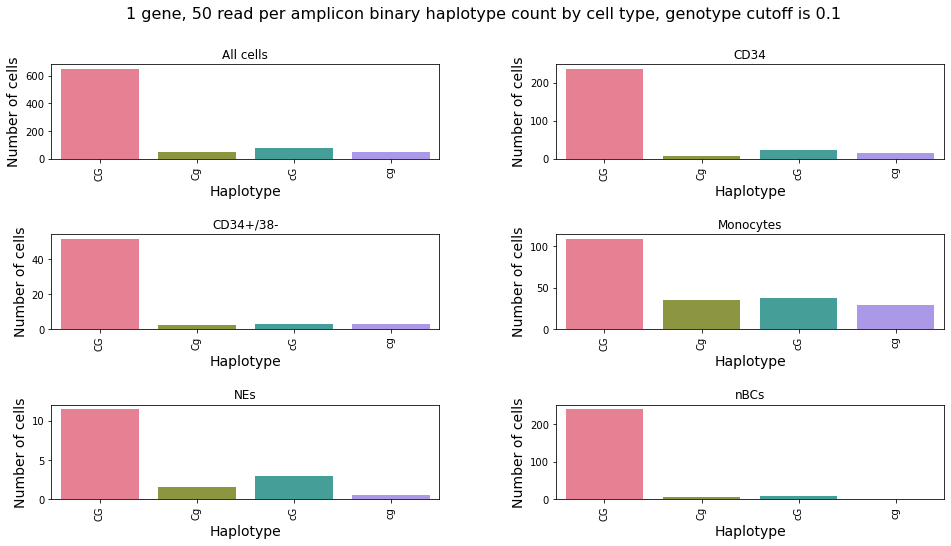

In [11]:
#Start with df3, gDNA amplicons gene1_50cut
cutoff3 = 0.1 #Put haplotype cutoff here

plate3 = RN_allele_plate[RN_allele_plate['Plate_Well'].isin(gene1_50cut)]
plate3 = plate3[plate3['Amplicon'].isin(gene1_50cut_amps)] #Need to manually add amplicons for each subset

#Calculate the allele frequency
plate3 = plate3.iloc[:, 0:1].unstack(level = 3)
plate3['Total'] = plate3.iloc[: , 0] + plate3.iloc[: , 1]
plate3['Mut_freq'] = plate3.iloc[:, 0]/plate3['Total']

#Assign Wt or MT to each allele
plate3 = plate3.drop(columns = ['Reads', 'Total'])

conditions = [(plate3['Mut_freq'] <= cutoff3), (plate3['Mut_freq']) > cutoff3 ]
values = ['w', 'm']
plate3['Genotype'] = np.select(conditions, values)
plate3 = plate3.drop(columns = ['Mut_freq']).unstack(2)
plate3.columns = gene1_50cut_amps

plate3.iloc[:,0].replace({'w':'C','m':'c' }, inplace = True)
plate3.iloc[:,1].replace({'w':'G','m':'g' }, inplace = True)

plate3['Haplotype'] = plate3.iloc[:,0] + plate3.iloc[:,1]
plate3['Cell_type'] = plate3.index.get_level_values(0)
plate3['Cell_type'] = plate3['Cell_type'].replace(plate_cell_dict)

print('The number of haplotypes present is: ', len(plate3['Haplotype'].drop_duplicates().to_list()))

#Plot two haplotype data for 3 gene 100 amplicon set - second method to add colour for each haplotype
fig, axes = plt.subplots(3,2, figsize = (16,8))
fig.subplots_adjust(hspace = 0.8, wspace=.3)
ax = axes.ravel()
count = 0

c = plate3['Haplotype'].value_counts().rename_axis('hap').reset_index(name='counts')

#if any haplotype is not present, add it into the frame with freq 0 hap_3gene_poss has the possibilities
for h in hap_2gene_poss:
    if h in c['hap']:
        continue
    else:
        dfh = pd.DataFrame([[h, 0]], columns= ['hap', 'counts'])
        c = c.append(dfh)
c['order'] = c['hap']
c = c.replace({'order': hap_2gene_order})
c = c.sort_values(by=['order'])        
d = c['counts'].sum()
c['proportion'] = c['counts']/d

ax[0] = sns.barplot(x='hap', y='counts', data = c, palette = col_2gene, ax = ax[0], ci = None) #fro scatter add  hue = 'hap'
ax[0].set_title('All cells') 
ax[0].set_ylabel('Number of cells', fontsize = 14)
ax[0].set_xlabel('Haplotype', fontsize = 14)
ax[0].tick_params(axis='x', labelrotation = 90)
#ax[0].set_ylim(0.001,0.999)
#ax[count].set_yscale('logit') #use this only with scatterplot

for cell in celltype:
    count += 1
    
    if plate3.loc[plate3['Cell_type'].isin([cell])].empty ==False:
    
        a = plate3.loc[plate3['Cell_type'].isin([cell])]['Haplotype'].value_counts().rename_axis('hap').reset_index(name='counts')
        
        #if any haplotype is not present, add it into the frame with freq 0 hap_3gene_poss has the possibilities
        for h in hap_2gene_poss:
            if h in a['hap']:
                continue
            else:
                dfh = pd.DataFrame([[h, 0]], columns= ['hap', 'counts'])
                a = a.append(dfh)        
        a['order'] = a['hap']
        a = a.replace({'order': hap_2gene_order})
        a = a.sort_values(by=['order']) 
        b = a['counts'].sum()
        a['proportion'] = a['counts']/b
    
        ax[count] = sns.barplot(x='hap', y='counts', data = a, palette = col_2gene, ax = ax[count], ci = None) #for scatter add  hue = 'hap'
        ax[count].set_title(str(cell)) 
        ax[count].set_ylabel('Number of cells', fontsize = 14)
        ax[count].set_xlabel('Haplotype', fontsize = 14)
        ax[count].tick_params(axis='x', labelrotation = 90)
        #ax[count].set_ylim(0.001,0.999)
        #ax[count].set_yscale('logit') #use this only with scatterplot
        
    else:
        continue

fig.suptitle('1 gene, 50 read per amplicon binary haplotype count by cell type, genotype cutoff is ' + str(cutoff3), fontsize=16)
fig.savefig('../Results/Haplotypes/Haplotype_1gen_50amp_cutoff_'+str(cutoff3)+ '.png',dpi=300)   
#plt.close()

In [12]:
#Start with df5, gDNA amplicons except TET2b, filter list gene3_100cut
cutoff5 = 0.1 #Put haplotype cutoff here

plate5 = RN_allele_plate[RN_allele_plate['Plate_Well'].isin(gene3_50cut)]
plate5 = plate5[plate5['Amplicon'].isin(gene3_50cut_amps)] #Need to manually add amplicons for each subset

#Calculate the allele frequency
plate5 = plate5.iloc[:, 0:1].unstack(level = 3)
plate5['Total'] = plate5.iloc[: , 0] + plate5.iloc[: , 1]
plate5['Mut_freq'] = plate5.iloc[:, 0]/plate5['Total']

#Assign Wt or MT to each allele
plate5 = plate5.drop(columns = ['Reads', 'Total'])

conditions = [(plate5['Mut_freq'] <= cutoff5), (plate5['Mut_freq']) > cutoff5 ]
values = ['w', 'm']
plate5['Genotype'] = np.select(conditions, values)
plate5 = plate5.drop(columns = ['Mut_freq']).unstack(2)
plate5.columns = gene3_100cut_amps

plate5.iloc[:,0].replace({'w':'R','m':'r' }, inplace = True)
plate5.iloc[:,1].replace({'w':'S','m':'s' }, inplace = True)
plate5.iloc[:,2].replace({'w':'A','m':'a' }, inplace = True)
plate5['Haplotype'] = plate5.iloc[:,1] + plate5.iloc[:,2] + plate5.iloc[:,0]
plate5['Cell_type'] = plate5.index.get_level_values(0)
plate5['Cell_type'] = plate5['Cell_type'].replace(plate_cell_dict)

print('The number of haplotypes present is: ', len(plate5['Haplotype'].drop_duplicates().to_list()))


The number of haplotypes present is:  8


In [13]:
#Create frequency tables for each haplotype for each plate - need to include 0 frequency for haplotypes that weren't observed
#List of possible haplotypes already generated hap_4gene_poss and hap_3gene_poss
total1 = plate1['Haplotype'].value_counts().sum()
counts1 = dict(plate1['Haplotype'].value_counts()/total1)
print('Plate1', cutoff1, len(counts1))

for hap in hap_3gene_poss:
    if hap in counts1.keys():
        continue
    else:
        counts1[hap] = 0

total2 = plate2['Haplotype'].value_counts().sum()
counts2 = dict(plate2['Haplotype'].value_counts()/total2)

for hap in hap_4gene_poss:
    if hap in counts2.keys():
        continue
    else:
        counts2[hap] = 0

print('Plate2', cutoff2, len(counts2))

total3 = plate3['Haplotype'].value_counts().sum()
counts3 = dict(plate3['Haplotype'].value_counts()/total3)
print('Plate3',cutoff3, len(counts3))

total4 = plate4['Haplotype'].value_counts().sum()
counts4 = dict(plate1['Haplotype'].value_counts()/total4)

for hap in hap_3gene_poss:
    if hap in counts4.keys():
        continue
    else:
        counts4[hap] = 0
        
print('Plate4', cutoff4, len(counts4))


Plate1 0.1 8
Plate2 0.2 16
Plate3 0.1 4
Plate4 0.1 8


In [14]:
trajectory4 = ['SABR', 'sABR', 'saBR', 'sabR', 'sabr']
trajectory3 = ['SAR', 'sAR', 'saR', 'sar']

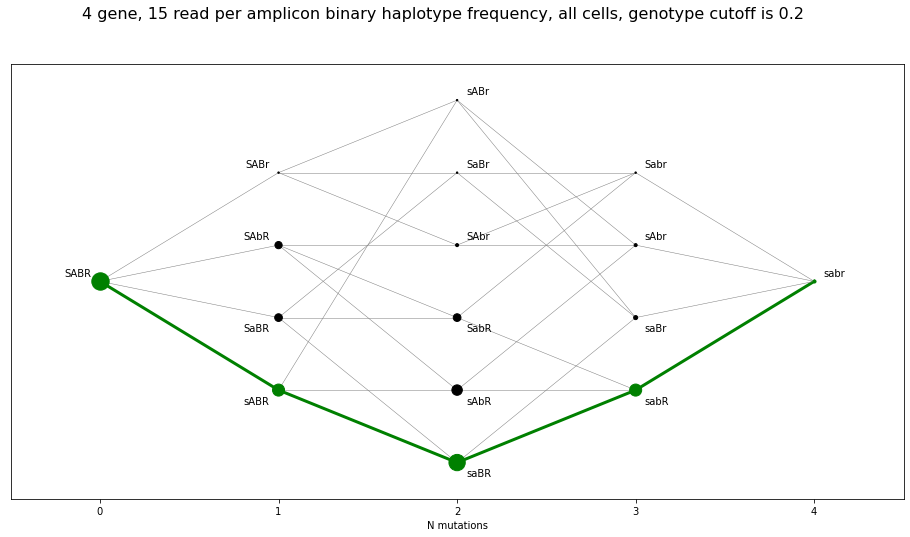

In [15]:
#Four haplotype graph
haplo_freqs = pd.DataFrame.from_dict(counts2, orient='index', columns = ['freq'])  #put the desired freq list here
cut = cutoff2 #put cutoff variable for data here

def count_muts(x):
    return (np.array(['S', 'A', 'B', 'R']) != list(x)).sum()

haplo_freqs['n_muts'] = [count_muts(x) for x in haplo_freqs['freq'].index] #Count of how many genes are mutated in that haplotype

hmax = haplo_freqs['freq'].max()
fig, ax = plt.subplots(figsize = (16,8))
for nmut in range(5):
    hap = haplo_freqs.loc[haplo_freqs['n_muts'] == nmut]
    nh = len(hap)
    ys = np.arange(nh) - 0.5 * (nh - 1)
    xs = [nmut] * len(ys)

    # Sizes
    #s = 2 + 150 * np.sqrt(hap['freq'].values / hmax)
    s = 2 + 300 * (hap['freq'].values / hmax)
    
    # Color
    c = ['green' if x in trajectory4 else 'k' for x in hap.index]

    ax.scatter(xs, ys, s=s, c=c)

    for hname, y in zip(hap.index, ys):
        if (y >= 0) & (nmut < 1.5):
            ax.text(nmut - 0.05, y + 0.05, hname, ha='right',
va='bottom')
        elif y >= 0:
            ax.text(nmut + 0.05, y + 0.05, hname, ha='left',
va='bottom')
        elif nmut < 1.5:
            ax.text(nmut - 0.05, y - 0.08, hname, ha='right', va='top')
        else:
            ax.text(nmut + 0.05, y - 0.08, hname, ha='left', va='top')

    if nmut != 4:
        hap2 = haplo_freqs.loc[haplo_freqs['n_muts'] == nmut + 1]
        nh2 = len(hap2)
        ys2 = np.arange(nh2) - 0.5 * (nh2 - 1)
        for hname, y in zip(hap.index, ys):
            for hname2, y2 in zip(hap2.index, ys2):
                skip = False
                for i in range(len(hname)):
                    if (hname[i] == hname[i].lower()) and (hname2[i] == hname2[i].upper()):
                        skip = True
                        break               
                
                if skip:
                    continue
                    
                
                
                if (trajectory4[nmut] == hname) and (trajectory4[nmut 
+ 1] == hname2):
                    lw = 3
                    color = 'green'
                else:
                    lw = 0.5
                    color = 'grey'
                ax.plot([nmut, nmut+1], [y, y2], color=color, lw=lw, zorder=0)

ax.set_xlim(-0.5, 4.5)
ax.set_xticks(np.arange(5))
ax.set_xlabel('N mutations')
ax.set_ylim(-3, 3)
ax.set_yticks([])
#fig.tight_layout()

fig.suptitle('4 gene, 15 read per amplicon binary haplotype frequency, all cells, genotype cutoff is ' + str(cutoff2), fontsize=16)
fig.savefig('../Results/Haplotypes/Haplotype_4gen_15amp_cutoff_trajectory'+str(cutoff2)+ '.png',dpi=300)

plt.ion(); plt.show()
#How to only show possible trajectories?

In [16]:
counts2

{'SABR': 0.25925925925925924,
 'saBR': 0.22839506172839505,
 'sABR': 0.12345679012345678,
 'sabR': 0.12345679012345678,
 'sAbR': 0.09259259259259259,
 'SaBR': 0.04938271604938271,
 'SabR': 0.04938271604938271,
 'SAbR': 0.043209876543209874,
 'saBr': 0.012345679012345678,
 'sAbr': 0.006172839506172839,
 'SAbr': 0.006172839506172839,
 'sabr': 0.006172839506172839,
 'SABr': 0,
 'SaBr': 0,
 'Sabr': 0,
 'sABr': 0}

In [17]:
#violin plots to go with the barplots (showing frequency)

In [18]:
a = RN_allele_plate.loc[RN_allele_plate['Plate'].isin(['AS-201'])]
b = a['Well'].drop_duplicates().to_list()
b
#a.loc[a['Well']]

['A1',
 'A2',
 'A3',
 'A4',
 'A5',
 'A6',
 'A7',
 'A8',
 'A9',
 'A10',
 'A11',
 'A12',
 'A13',
 'A14',
 'A15',
 'A16',
 'A17',
 'A18',
 'A19',
 'A20',
 'A21',
 'A22',
 'A23',
 'A24',
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B9',
 'B10',
 'B11',
 'B12',
 'B13',
 'B14',
 'B15',
 'B16',
 'B17',
 'B18',
 'B19',
 'B20',
 'B21',
 'B22',
 'B23',
 'B24',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21',
 'C22',
 'C23',
 'C24',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'D16',
 'D17',
 'D18',
 'D19',
 'D20',
 'D21',
 'D22',
 'D23',
 'D24',
 'E1',
 'E2',
 'E3',
 'E4',
 'E5',
 'E6',
 'E7',
 'E8',
 'E9',
 'E10',
 'E11',
 'E12',
 'E13',
 'E14',
 'E15',
 'E16',
 'E17',
 'E18',
 'E19',
 'E20',
 'E21',
 'E22',
 'E23',
 'E24',
 'F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'F8',
 'F9',
 'F10',
 'F11',
 'F12'

In [19]:
#Still to do here...

In [20]:
# Now have 4 plates of data, each with different cutoffs and haplotypes. Now want to introduce the index information

In [47]:
#Import indexing information. Currently just have BM index, trying to code to add in other indexing if we get it later.
idx = pd.read_csv('../Data/RN_comp_celltype_assignment.tsv', sep = '\t',  index_col = 0)
len(idx)

6974

In [259]:
#Import indexing plus other data
#Import indexing information. Currently just have BM index, trying to code to add in other indexing if we get it later.
idxall_BM = pd.read_csv('../Data/RN_BM_alldata_index.tsv', sep = '\t',  index_col = 0)
idxall = idxall_BM.copy() #Later - read in index info from other cells, and add code to combine 
len(idxall)

1259

In [260]:
print(plate_key)

('Cells with 100 reads for 3 genes (plate1), Cells with 15 reads for 4 genes (plate2), Cells with 50 reads for RUNX1 cDNA and gDNA (plate3), Cells with 10 reads for 4 genes (plate4)', 'Cells with 50 reads for 4 genes (plate 5)')


In [50]:
#Add index info to each plate made above
platelist = [plate1, plate2, plate3, plate4, plate5]
platelist2 = ['plate1', 'plate2', 'plate3', 'plate4','plate5']

plate_dict = {}

for p, l in zip(platelist, platelist2):
    pl = p.copy()
    #reconfigure plate
    pl['Plate'] = pl.index.get_level_values(0)
    pl['Well'] = pl.index.get_level_values(1)
    pl['Plate_Well'] = pl['Plate'].astype(str) + '_' + pl['Well'].astype(str)
    pl = pl.drop(columns = ['Plate', 'Well'])
    #merge with index data
    result = pd.merge(pl, idx, on = 'Plate_Well')
    plate_dict[l] = result
    
idx_plate1 = plate_dict['plate1']
idx_plate2 = plate_dict['plate2']
idx_plate3 = plate_dict['plate3']
idx_plate4 = plate_dict['plate4']
idx_plate5 = plate_dict['plate5']

a = idx_plate1.groupby(['Haplotype', 'celltype']).size().unstack(fill_value = 0)
print(a.sum())
a = a * 100 /a.sum(axis = 0)
#a = a.T
#a['total'] = a.sum(axis = 0)
a

celltype
CD14neg_mono    104
CD14pos_mono      5
CMP              41
GMP             147
GMP2             31
HSC               5
MDS_SC           47
MEP              61
MPP              19
NE               15
nBC             310
unassigned        7
dtype: int64


celltype,CD14neg_mono,CD14pos_mono,CMP,GMP,GMP2,HSC,MDS_SC,MEP,MPP,NE,nBC,unassigned
Haplotype,,,,,,,,,,,,
SAR,2.884615,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,10.526316,6.666667,84.516129,0.000000
SAr,0.961538,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.322581,0.000000
SaR,6.730769,0.0,0.000000,0.000000,0.000000,20.0,0.000000,0.000000,0.000000,26.666667,10.967742,14.285714
Sar,0.961538,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,13.333333,0.000000,0.000000
sAR,17.307692,40.0,12.195122,14.965986,12.903226,20.0,19.148936,16.393443,26.315789,0.000000,2.903226,0.000000
sAr,6.730769,0.0,4.878049,0.680272,0.000000,0.0,6.382979,1.639344,0.000000,6.666667,0.000000,14.285714
saR,36.538462,40.0,75.609756,78.911565,87.096774,60.0,65.957447,75.409836,63.157895,40.000000,1.290323,71.428571
sar,27.884615,20.0,7.317073,5.442177,0.000000,0.0,8.510638,6.557377,0.000000,6.666667,0.000000,0.000000


In [51]:
c = a[['HSC','MDS_SC','MPP','CMP','MEP', 'GMP', 'GMP2', 'CD14neg_mono', 'NE',  'nBC', 'unassigned']]
c

celltype,HSC,MDS_SC,MPP,CMP,MEP,GMP,GMP2,CD14neg_mono,NE,nBC,unassigned
Haplotype,,,,,,,,,,,
SAR,0.0,0.000000,10.526316,0.000000,0.000000,0.000000,0.000000,2.884615,6.666667,84.516129,0.000000
SAr,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.961538,0.000000,0.322581,0.000000
SaR,20.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.730769,26.666667,10.967742,14.285714
Sar,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.961538,13.333333,0.000000,0.000000
sAR,20.0,19.148936,26.315789,12.195122,16.393443,14.965986,12.903226,17.307692,0.000000,2.903226,0.000000
sAr,0.0,6.382979,0.000000,4.878049,1.639344,0.680272,0.000000,6.730769,6.666667,0.000000,14.285714
saR,60.0,65.957447,63.157895,75.609756,75.409836,78.911565,87.096774,36.538462,40.000000,1.290323,71.428571
sar,0.0,8.510638,0.000000,7.317073,6.557377,5.442177,0.000000,27.884615,6.666667,0.000000,0.000000


In [49]:
b = a[['HSC','MDS_SC','MPP','CMP','MEP', 'GMP', 'GMP2', 'CD14neg_mono', 'NE',   'nBC', 'unassigned']]
b

celltype,HSC,MDS_SC,MPP,CMP,MEP,GMP,GMP2,CD14neg_mono,NE,nBC,unassigned
Haplotype,,,,,,,,,,,
SAR,0.000000,0.000000,6.25,0.000000,0.000000,0.000000,0.000000,1.562500,5.714286,83.516484,0.000000
SAr,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,1.562500,0.000000,2.197802,0.000000
SaR,14.285714,2.197802,0.00,0.000000,0.000000,0.000000,0.000000,6.250000,17.142857,9.670330,11.111111
Sar,0.000000,0.000000,0.00,0.000000,0.000000,0.465116,0.000000,1.562500,5.714286,0.000000,0.000000
sAR,28.571429,14.285714,18.75,11.320755,18.604651,13.488372,10.810811,15.104167,11.428571,3.076923,11.111111
sAr,0.000000,3.296703,0.00,5.660377,1.162791,0.930233,0.000000,5.208333,5.714286,0.000000,11.111111
saR,57.142857,71.428571,75.00,77.358491,73.255814,79.534884,86.486486,40.625000,37.142857,1.538462,66.666667
sar,0.000000,8.791209,0.00,5.660377,6.976744,5.581395,2.702703,28.125000,17.142857,0.000000,0.000000


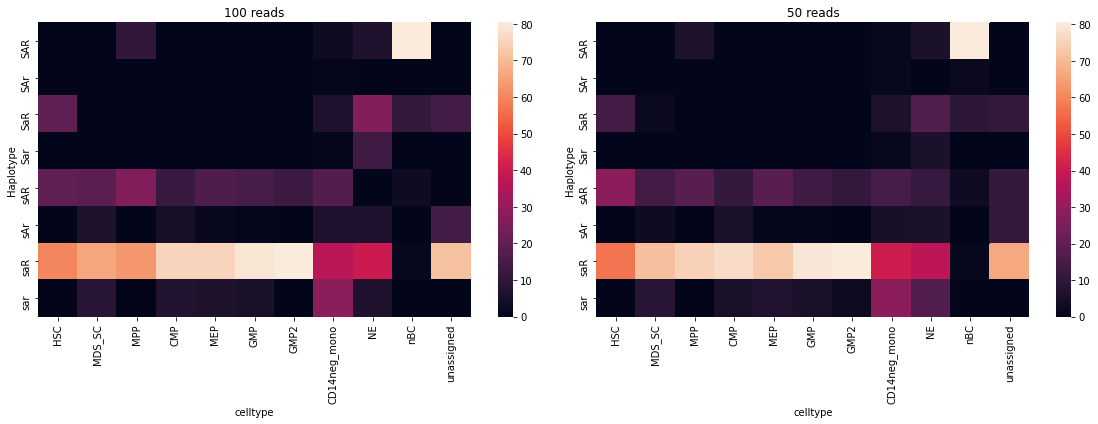

In [52]:
fig, ax = plt.subplots(1,2, figsize = (16, 6))
ax = ax.ravel()
count = -1

plots = [c,b]
titles = ['100 reads', '50 reads']

for x,y in zip(plots, titles):
    count+=1
    ax[count] = sns.heatmap(data = x, ax = ax[count], robust = True)
    ax[count].set_title(y)

fig.tight_layout()
fig.savefig('../Results/Index_Haps/Index_Hap_heatmap_3gen',dpi=600)

KeyError: 'FSC-A'

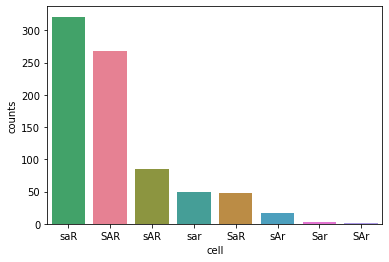

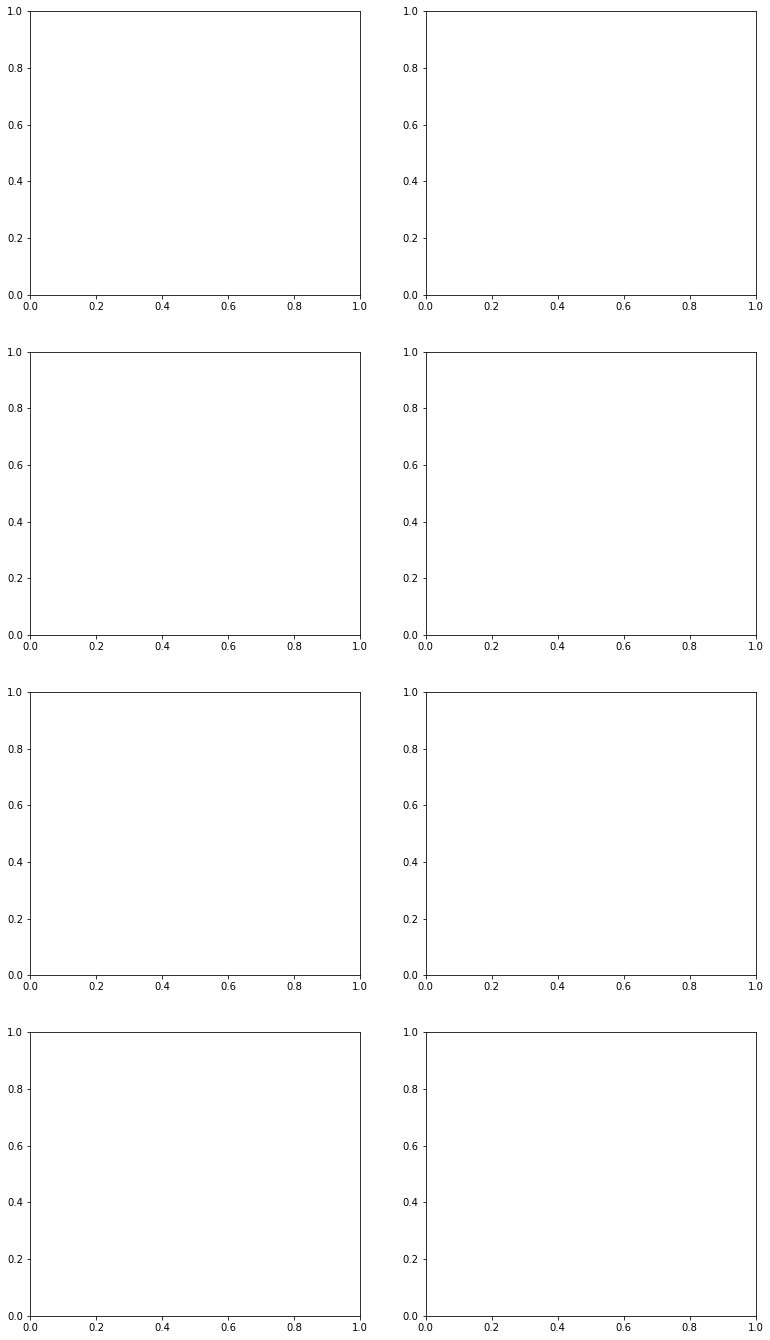

In [265]:
#Noe let's plot by genotype

sourcedata = idx_plate1.copy()  #Can swap to a different df here 

#Here's what's being plotted
plot_list = [
    ['FSC-A', 'SSC-A'],
    ['FSC-A', 'FSC-W'],
    ['SSC-A', 'SSC-H'],
    ['Zombie', 'Lin-PE-Cy5'], 
    ['CD34-PE', 'CD38-APC-cy7'],
    ['IL1RAP-APC', 'CD38-APC-cy7'],
    ['CD45RA-FITC', 'CD123-PE-Cy7'],
    ['CD45RA-FITC', 'CD90-BV421']
     
]

#Define colour palette here, and make a new column for it (c=  can only take a number or colour, not a categorical)
ct = sourcedata['Haplotype'].drop_duplicates().to_list()
col = sns.color_palette('husl', n_colors = len(ct))
palette = dict(zip(ct, col))

sourcedata['Colour'] = sourcedata['Haplotype'].map(palette)

#Make a plot of cell type distributions

c = sourcedata['Haplotype'].value_counts().rename_axis('cell').reset_index(name='counts')
sns.barplot(x='cell', y='counts', data = c, palette = palette)

#Proposed gate locations
gate_loc = {
    'Lin-PE-Cy5': 2000,
    'CD34-PE': 280 ,
    'CD38-APC-cy7': 3000 ,
    'CD45RA-FITC': 1500 ,
    'CD123-PE-Cy7': 400,
    'Zombie': 8000,
    'IL1RAP-APC': 1200,
    'CD90-BV421': 500,
}

#Which fluorophores are on a log scale
logs = ['Lin-PE-Cy5', 'CD34-PE','CD38-APC-cy7', 'CD45RA-FITC','CD123-PE-Cy7','Zombie', 'IL1RAP-APC', 'CD90-BV421' ]

fix, axs = plt.subplots(4,2, figsize = (13,24))
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.3, wspace=.3)

for ax,y in zip(axs, plot_list):
    x_label = y[0]
    y_label = y[1]
    ax.scatter(sourcedata[x_label] + 11, sourcedata[y_label] + 11, alpha = 0.5, c = sourcedata['Colour'], s = 5)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
   #ax.legend()
    if x_label in logs:
        ax.set_xscale('log')
        ax.set_xlim(left = 10)
    if y_label in logs:
        ax.set_yscale('log')
        ax.set_ylim(bottom = 10)
    if x_label in gate_loc:
        ax.axvline(gate_loc[x_label], ls = '--', c = 'k')
    if y_label in gate_loc:
        ax.axhline(gate_loc[y_label], ls = '--', c = 'k')   
        
    ax.autoscale_view()  
    
fig.tight_layout()    